# Index

1. [Imports](#Imports)
2. [Creating the Data Set (Images)](#Creating-the-Data-Set-Images)
     - [Preprocess images](#Preprocess-images)
     - [Split the data](#Split-the-data)
3. [Data Augmentation for Training and Validation](#Data-Augmentation-for-Training-and-Validation)
   - [Visualizing the final augmented images and the bboxes](#Visualizing-the-final-augmented-images-and-the-bboxes)
   - [Dataset](#Dataset)

## Imports

In [113]:
# ======================
# OS AND FILE MANAGEMENT
# ======================
import shutil
import random
from glob import glob
import pickle
import re
import xml.etree.ElementTree as ET

import sys
import os

# Go 2 levels up from current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Add to sys.path if not present
if project_root not in sys.path:
    sys.path.insert(0, project_root)


# ================================
# SCIENTIFIC COMPUTING + DATA I/O
# ================================
import numpy as np
import pandas as pd

# ==================
# IMAGE PROCESSING
# ==================
import cv2
import pydicom

# Image Augmentation (Albumentations)
from albumentations import (
    Compose, HorizontalFlip, RandomBrightnessContrast, Affine,
    GaussianBlur, CLAHE, RandomGamma, GaussNoise
)

# ================
# VISUALIZATION
# ================
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ===========================
# MACHINE LEARNING UTILITIES
# ===========================
from sklearn.model_selection import train_test_split
from collections import defaultdict

# ===========================
# CUSTOM PROJECT IMPORTS
# (new structure under src/)
# ===========================

# --- Preprocessing ---
from src.preprocessing.uid_mapping import getUID_path
from src.preprocessing.dicom_io import read_dicom_image
from src.preprocessing.xml_parsing import extract_bounding_boxes
from src.preprocessing.dataset_building import (
    create_dataset,
    get_images_by_patient_id
)
from src.preprocessing.yolo_conversion import preprocess_images

# Balanced sampling utilities
from src.preprocessing.sampling import (
    relaxed_stratified_sample,
    add_more_patients,
    get_target_sample,
    adjust_sample_size,
    calculate_stage_distribution,
    compare_distributions,
    check_balance
)

# --- Augmentation ---
from src.augmentation.augmentation_yolo import (
    augment_yolo_images_train,
    augment_yolo_images_val
)

# --- Splitting ---
from src.splitting.dataset_splitting import split_data

# --- Statistics ---
from src.statistics.patient_label_statistics import (
    count_labels_by_class,
    count_labels_by_class_and_source,
    count_images_labels_patients_by_class
)

# --- Visualization ---
from src.visualization.plot_bboxes import (
    visualize_image_with_bboxes,
    visualize_image_with_bboxes_legend
)
from src.visualization.patient_visualization import visualize_image_by_uid
from src.visualization.yolo_visualization import visualize_yolo_images

# --- Utility Tools ---
from src.utils.file_utils import (
    load_dataset,
    loadFileInformation
)
    
from src.utils.extract_number import extract_number
from src.utils.subject_utils import (
    count_unique_subject_ids,
    patient_count_by_group,
    count_labels_by_class_and_source,
    count_labels_by_class,
    count_images_labels_patients_by_class
)   

# Creating the Data Set (Images)

## Preprocess images

In [79]:
image_dir = os.path.join('../../data/sampled', 'Final_Images', 'Lung-PET-CT-Dx')
annotation_dir = os.path.join('../../data/raw', 'Annotation')
output_dir = os.path.join('../../data/yolo', 'yolo_orig')

In [80]:
class_counts, patient_ids = count_images_labels_patients_by_class(output_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class E: 201 images, 201 labels, 5 unique patients

List of unique patient IDs by class:
Class B: 3021 images, 3021 labels, 37 unique patients

List of unique patient IDs by class:
Class G: 3476 images, 3476 labels, 38 unique patients

List of unique patient IDs by class:
Class A: 3529 images, 3529 labels, 77 unique patients

List of unique patient IDs by class:
Class E: ['E0001', 'E0002', 'E0003', 'E0004', 'E0005']
Class B: ['B0001', 'B0002', 'B0003', 'B0004', 'B0005', 'B0006', 'B0007', 'B0008', 'B0009', 'B0011', 'B0013', 'B0014', 'B0015', 'B0016', 'B0017', 'B0018', 'B0019', 'B0020', 'B0021', 'B0022', 'B0023', 'B0024', 'B0025', 'B0026', 'B0027', 'B0028', 'B0031', 'B0033', 'B0034', 'B0036', 'B0037', 'B0038', 'B0040', 'B0041', 'B0042', 'B0043', 'B0044']
Class G: ['G0001', 'G0002', 'G0003', 'G0004', 'G0005', 'G0006', 'G0007', 'G0008', 'G0010', 'G0011', 'G0012', 'G0013', 'G0014', 'G0015', 'G0017', 'G0018', 'G0019', 'G0024', 'G0025', 'G0026'

## Split the data
* Data was splited **70% train, 15% val, 15% test**

In [81]:
input_dir = os.path.join('../../data/yolo', 'yolo_orig')
output_dir = os.path.join('../../data/yolo', 'patient_split')

### **Train Data (70%)**

In [89]:
split_dir_train = os.path.join('../../data/yolo', 'patient_split/train')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir_train)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class E: 79 images, 79 labels, 3 unique patients

List of unique patient IDs by class:
Class B: 2303 images, 2303 labels, 27 unique patients

List of unique patient IDs by class:
Class G: 2566 images, 2566 labels, 29 unique patients

List of unique patient IDs by class:
Class A: 2546 images, 2546 labels, 59 unique patients

List of unique patient IDs by class:
Class E: ['E0001', 'E0002', 'E0004']
Class B: ['B0001', 'B0002', 'B0003', 'B0004', 'B0005', 'B0006', 'B0007', 'B0008', 'B0009', 'B0013', 'B0014', 'B0015', 'B0016', 'B0019', 'B0021', 'B0022', 'B0023', 'B0026', 'B0031', 'B0033', 'B0036', 'B0037', 'B0038', 'B0040', 'B0042', 'B0043', 'B0044']
Class G: ['G0002', 'G0003', 'G0004', 'G0005', 'G0006', 'G0007', 'G0011', 'G0013', 'G0014', 'G0015', 'G0017', 'G0018', 'G0019', 'G0024', 'G0025', 'G0026', 'G0028', 'G0029', 'G0031', 'G0032', 'G0036', 'G0039', 'G0040', 'G0041', 'G0043', 'G0044', 'G0050', 'G0056', 'G0062']
Class A: ['A0001', 'A0003',

### **Validation Data (15%)**

In [90]:
split_dir_val = os.path.join('../../data/yolo', 'patient_split/val')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir_val)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class E: 79 images, 79 labels, 1 unique patients

List of unique patient IDs by class:
Class B: 364 images, 364 labels, 5 unique patients

List of unique patient IDs by class:
Class G: 424 images, 424 labels, 4 unique patients

List of unique patient IDs by class:
Class A: 508 images, 508 labels, 10 unique patients

List of unique patient IDs by class:
Class E: ['E0003']
Class B: ['B0020', 'B0024', 'B0025', 'B0027', 'B0034']
Class G: ['G0008', 'G0010', 'G0033', 'G0046']
Class A: ['A0010', 'A0013', 'A0019', 'A0021', 'A0022', 'A0086', 'A0149', 'A0162', 'A0169', 'A0183']


### **Test Data (15%)**

In [91]:
split_dir = os.path.join('../../data/yolo', 'patient_split/test')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class E: 43 images, 43 labels, 1 unique patients

List of unique patient IDs by class:
Class B: 354 images, 354 labels, 5 unique patients

List of unique patient IDs by class:
Class G: 486 images, 486 labels, 5 unique patients

List of unique patient IDs by class:
Class A: 475 images, 475 labels, 8 unique patients

List of unique patient IDs by class:
Class E: ['E0005']
Class B: ['B0011', 'B0017', 'B0018', 'B0028', 'B0041']
Class G: ['G0001', 'G0012', 'G0030', 'G0042', 'G0049']
Class A: ['A0053', 'A0059', 'A0097', 'A0109', 'A0135', 'A0163', 'A0184', 'A0187']


## Data Augmentation for Training and Validation

<span style="font-size:18px; font-weight:bold;">Purpose of Augmentation</span>  
Data augmentation is used to artificially expand the training dataset by applying transformations to existing images. This helps improve the model's generalization by exposing it to a variety of variations and preventing overfitting.  
<br>
<span style="font-size:18px; font-weight:bold;">Augmentation Strategies for Training</span>  
In the training dataset, different augmentation pipelines were applied to balance the class distribution and enhance the dataset's diversity. Special consideration was given to **Class E**, which had only **201 images** compared to the **other classes with over 3,000 images**. To account for this imbalance, **more intensive augmentations** were applied to Class E to generate a sufficient number of diverse samples.  
* All images were augmented until they **reached the same number of images as the class with the most images** (in this case until they reached **2566 images** - same number as the class G).  
<br>

<span style="font-size:16px; font-weight:bold;">Transformations Applied:</span>  
1. **Horizontal Flip**: Introduced variation by flipping images horizontally.  
2. **Random Brightness/Contrast**: Adjusted brightness and contrast to simulate different imaging conditions.  
3. **Affine Transformations**:  
   - Small translations (e.g., 1-2%) and scaling (e.g., 95%-105%).  
   - Slight rotations (e.g., -2° to 2°) to mimic slight misalignments.  
4. **Gaussian Blur**: Added blur to simulate lower-quality imaging conditions.  
5. **CLAHE (Contrast Limited Adaptive Histogram Equalization)**: Enhanced local contrast in images.  
6. **Random Gamma Adjustments**: Adjusted image gamma to alter overall brightness.  

For Class B and E, the **intense augmentation pipeline** included:  
- Larger translations (5%-10%) and scaling variations (80%-120%).  
- More pronounced rotations (-10° to 10°) and shear transformations (-5° to 5°).  
- Increased blur and contrast adjustments to maximize variation.  
<br>

<span style="font-size:18px; font-weight:bold;">Contextual Considerations</span>  
Since the data consists of **CT/PET scans**, it was important to apply transformations that preserve the anatomical and diagnostic integrity of the images. For example:  
- **Rotations and translations** were kept small to avoid unrealistic spatial changes.  
- **Brightness/contrast adjustments** were restricted to values that align with possible differences in imaging modalities.  
- **Gaussian blur** and **CLAHE** simulated conditions such as scanner noise or imaging artifacts.  
<br>

<span style="font-size:18px; font-weight:bold;">Augmentation for Validation</span>  
For the validation dataset, fewer augmentations were applied to ensure that the data closely resembles real-world conditions. The augmentations for validation included:  
1. **Horizontal Flip (5%)**: Small chance of flipping for minor variation.  
2. **Random Brightness/Contrast (3%-5%)**: Simulated subtle differences in imaging conditions.  
3. **Affine Transformations**:  
   - Tiny translations (1%-2%) and scaling (95%-105%).  
   - Slight rotations (-2° to 2°).  
* All images were augmented until they **reached the same number of images as the class with the most images** (in this case until they reached **508 images** - same number as the class A).  
<br>

<span style="font-size:18px; font-weight:bold;">Rationale for Choosing Augmentations</span>  
- CT/PET scans are highly sensitive to transformations that distort anatomical features. Therefore, care was taken to ensure that augmentations like large rotations or extreme brightness changes were avoided.  
- **For training**: Aggressive augmentations were used for the underrepresented Class E to create enough diverse samples without straying too far from realistic imaging.  
- **For validation**: Minimal augmentations were applied to mimic real-world test data, ensuring the evaluation remained unbiased.


### **Train**

In [101]:
input_dir_train= os.path.join('../../data/yolo', 'patient_split/train')
output_dir_train= os.path.join('../../data/yolo', 'patient_split_augmented/train')

In [102]:
split_dir = os.path.join('../../data/yolo', 'patient_split_augmented/train')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class E: 2566 images, 2566 labels, 3 unique patients

List of unique patient IDs by class:
Class B: 2566 images, 2566 labels, 27 unique patients

List of unique patient IDs by class:
Class G: 2566 images, 2566 labels, 29 unique patients

List of unique patient IDs by class:
Class A: 2566 images, 2566 labels, 59 unique patients

List of unique patient IDs by class:
Class E: ['E0001', 'E0002', 'E0004']
Class B: ['B0001', 'B0002', 'B0003', 'B0004', 'B0005', 'B0006', 'B0007', 'B0008', 'B0009', 'B0013', 'B0014', 'B0015', 'B0016', 'B0019', 'B0021', 'B0022', 'B0023', 'B0026', 'B0031', 'B0033', 'B0036', 'B0037', 'B0038', 'B0040', 'B0042', 'B0043', 'B0044']
Class G: ['G0002', 'G0003', 'G0004', 'G0005', 'G0006', 'G0007', 'G0011', 'G0013', 'G0014', 'G0015', 'G0017', 'G0018', 'G0019', 'G0024', 'G0025', 'G0026', 'G0028', 'G0029', 'G0031', 'G0032', 'G0036', 'G0039', 'G0040', 'G0041', 'G0043', 'G0044', 'G0050', 'G0056', 'G0062']
Class A: ['A0001', 'A00

### **Validation**

In [108]:
input_dir_val= os.path.join('../../data/yolo', 'patient_split/val')
output_dir_val= os.path.join('../../data/yolo', 'patient_split_augmented/val')

In [109]:
augment_yolo_images_val(input_dir_val, output_dir_val, 508, target_size=(512, 512))


Augmentation completed.
  Total images for Class 1 after augmentation: 508
  Total images for Class 3 after augmentation: 508
  Total images for Class 2 after augmentation: 508
  Total images for Class 0 after augmentation: 508


In [110]:
split_dir = os.path.join('../../data/yolo', 'patient_split_augmented/val')
class_counts, patient_ids = count_images_labels_patients_by_class(split_dir)

print("Counts of images, labels, and patients by class:")
for class_id, counts in class_counts.items():
    print(f"Class {class_id}: {counts['images']} images, {counts['labels']} labels, {counts['patients']} unique patients")

    print("\nList of unique patient IDs by class:")
for class_id, ids in patient_ids.items():
    print(f"Class {class_id}: {ids}")

Counts of images, labels, and patients by class:
Class E: 508 images, 508 labels, 1 unique patients

List of unique patient IDs by class:
Class B: 508 images, 508 labels, 5 unique patients

List of unique patient IDs by class:
Class G: 508 images, 508 labels, 4 unique patients

List of unique patient IDs by class:
Class A: 508 images, 508 labels, 10 unique patients

List of unique patient IDs by class:
Class E: ['E0003']
Class B: ['B0020', 'B0024', 'B0025', 'B0027', 'B0034']
Class G: ['G0008', 'G0010', 'G0033', 'G0046']
Class A: ['A0010', 'A0013', 'A0019', 'A0021', 'A0022', 'A0086', 'A0149', 'A0162', 'A0169', 'A0183']


### Vizualizing the final augmented images and the bboxes

UID: E0003, Image: E0003_1.3.6.1.4.1.14519.5.2.1.6655.2359.638278170119570191118328481805_aug_385.jpg


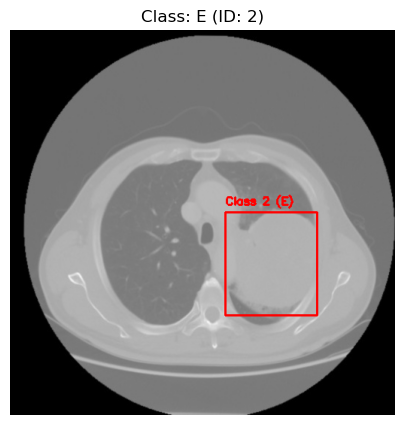

UID: A0022, Image: A0022_1.3.6.1.4.1.14519.5.2.1.6655.2359.742707935365966191542146964353.jpg


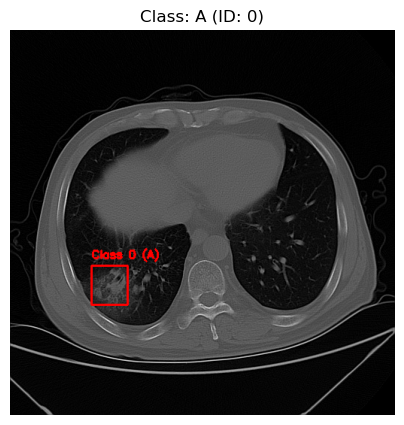

UID: A0169, Image: A0169_1.3.6.1.4.1.14519.5.2.1.6655.2359.746406079610533415416047086946.jpg


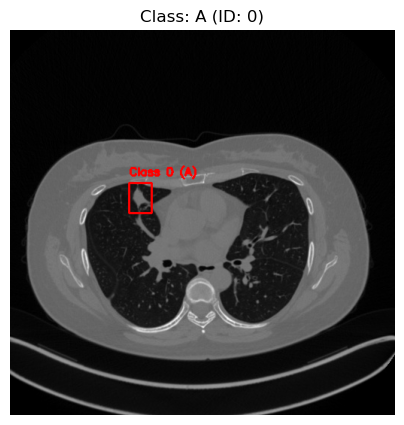

UID: A0183, Image: A0183_1.3.6.1.4.1.14519.5.2.1.6655.2359.302035177996903800780238571228.jpg


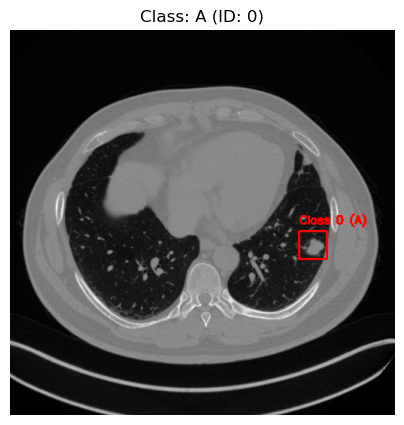

UID: A0162, Image: A0162_1.3.6.1.4.1.14519.5.2.1.6655.2359.556121089498864651378897680023.jpg


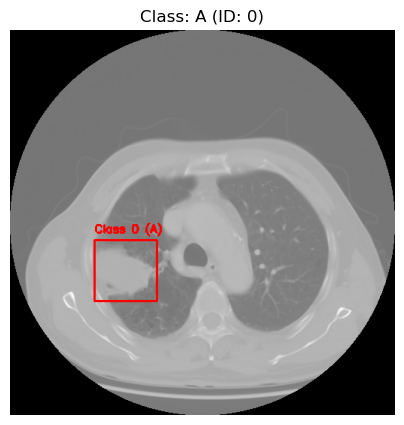

In [111]:
class_mapping = {
    "A": 0,  # Adenocarcinoma
    "B": 1,  # Small Cell Carcinoma
    "E": 2,  # Large Cell Carcinoma
    "G": 3   # Squamous Cell Carcinoma
}
visualize_yolo_images(split_dir, class_mapping, num_images=5)

## Dataset

This dataset has the original dicom images (to compare and check if the .jpg images and bbxes had any problem during augmentation)

In [116]:
dataset = load_dataset('../../data/dataset/final_images_dataset.pkl')

In [117]:
print(f"Total number of samples in the dataset: {len(dataset)}")

Total number of samples in the dataset: 10301


UID: 1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543495374569818432657
Patient ID: A0001
Description: 04-04-2007-NA-Chest-07990
Subdescription: 2.000000-5mm-40805
Filename: 1-13.dcm
Image shape: (512, 512)
Bounding Boxes: [[301, 329, 351, 372]]

Sample 1:
UID: 1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543495374569818432657
Patient ID: A0001
Description: 04-04-2007-NA-Chest-07990
Subdescription: 2.000000-5mm-40805
Filename: 1-13.dcm
Bounding Boxes: [[301, 329, 351, 372]]


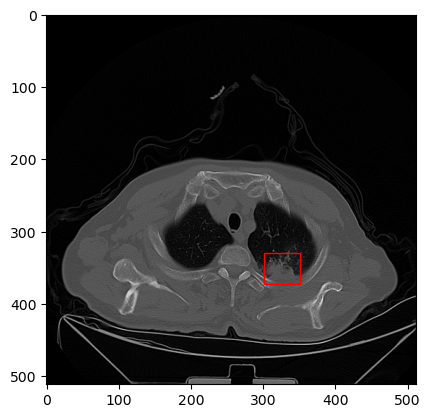


Sample 2:
UID: 1.3.6.1.4.1.14519.5.2.1.6655.2359.264364194296293440320787350583
Patient ID: A0001
Description: 04-04-2007-NA-Chest-07990
Subdescription: 2.000000-5mm-40805
Filename: 1-14.dcm
Bounding Boxes: [[287, 324, 354, 377]]


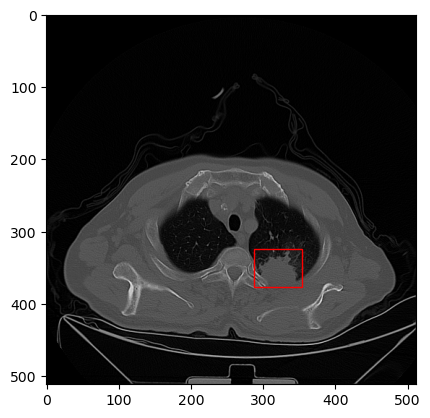

In [118]:
if dataset:
    # Access the first entry in the dataset
    first_entry = dataset[0]
    uid = first_entry["Uid"]
    image = first_entry["Image"]
    bboxes = first_entry["BoundingBoxes"]
    patient_id = first_entry["Patient ID"]
    description = first_entry["Description"]
    subdescription = first_entry["Subdescription"]
    filename = first_entry["Filename"]

    print(f"UID: {uid}")
    print(f"Patient ID: {patient_id}")
    print(f"Description: {description}")
    print(f"Subdescription: {subdescription}")
    print(f"Filename: {filename}")
    print(f"Image shape: {image.shape}")
    print(f"Bounding Boxes: {bboxes}")

    # Visualize the first 2 images in the dataset
    for i, entry in enumerate(dataset[:2]):
        image = entry["Image"]
        bboxes = entry["BoundingBoxes"]
        patient_id = entry["Patient ID"]
        description = entry["Description"]
        subdescription = entry["Subdescription"]
        filename = entry["Filename"]
        uid = entry["Uid"]

        print(f"\nSample {i+1}:")
        print(f"UID: {uid}")
        print(f"Patient ID: {patient_id}")
        print(f"Description: {description}")
        print(f"Subdescription: {subdescription}")
        print(f"Filename: {filename}")
        print(f"Bounding Boxes: {bboxes}")

        # Call the visualization function|
        visualize_image_with_bboxes(image, bboxes)
else:
    print("Dataset is empty.")

Total number of images for patient A0001: 20
Image 1 for patient A0001 with description 04-04-2007-NA-Chest-07990, subdescription 2.000000-5mm-40805, and filename 1-13.dcm:


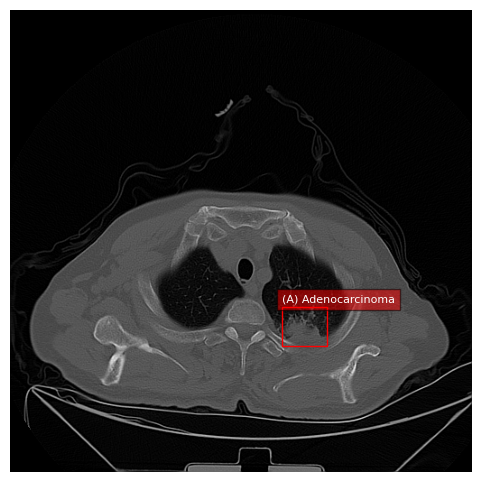

In [125]:
patient_id_to_search = 'A0001'
patient_images = get_images_by_patient_id(dataset, patient_id_to_search)
print(f"Total number of images for patient {patient_id_to_search}: {len(patient_images)}")

# Visualize only the first 3 images for the specified patient
for i, (image, bboxes, description, subdescription, filename) in enumerate(patient_images):
    if i >= 1:
        break  # Stop after displaying the first 3 images
    print(f"Image {i+1} for patient {patient_id_to_search} with description {description}, subdescription {subdescription}, and filename {filename}:")
    visualize_image_with_bboxes_legend(image, bboxes, 'A0001')

### Validate the jpg images against the datset

UID: 1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543495374569818432657
Patient ID: A0001
Description: 04-04-2007-NA-Chest-07990
Subdescription: 2.000000-5mm-40805
Filename: 1-13.dcm
Bounding Boxes: [[301, 329, 351, 372]]


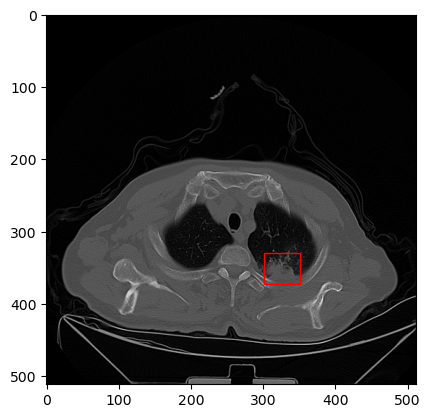

In [126]:
# Image UiD
target_uid = "1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543495374569818432657"  
visualize_image_by_uid(dataset, target_uid)